In [1]:
# 1
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.sparse as ss
from scipy import stats
from fenics import *

# import scipy.linalg as sl


# from mpl_toolkits.mplot3d import Axes3D
# from mshr import *
# from ufl import nabla_grad, nabla_div, grad
# from scipy.interpolate import interp2d
# from abc import abstractmethod

%matplotlib notebook

In [2]:
mat = scipy.io.loadmat('../../Matlab/Nestorowa2016_scRNAseqData.mat')

In [3]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Aug 11 22:07:10 2019',
 '__version__': '1.0',
 '__globals__': ['genename'],
 'cluster': array([[6, 2, 8, ..., 6, 3, 4]], dtype=uint8),
 'genename': array([[array(['x1110032F04Rik'], dtype='<U14'),
         array(['x1110059E24Rik'], dtype='<U14'),
         array(['x1300017J02Rik'], dtype='<U14'), ...,
         array(['Zxdc'], dtype='<U4'), array(['Zyx'], dtype='<U3'),
         array(['Zzz3'], dtype='<U4')]], dtype=object),
 'scdata': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 2.79518855, 1.3264775 , ..., 9.63103154, 2.78082166,
         7.64974439],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 5.57727096, ..., 1.43654788, 0.        ,
         1.51104603],
        [9.16437036, 9.14316782, 4.13642566, ..., 3.25302426, 2.78082166,
         5.50474711],

In [5]:
mat['scdata'].shape

(3991, 1644)

In [6]:
scdata= np.log2(mat['scdata']+ 1)

In [7]:
scdata.shape

(3991, 1644)

In [8]:
DMsig = 50 
N = np.array([100, 120])
no_dims = 20
alpha = 0.5

In [10]:
# DiffusionMap_wNewData.m
# [dc, dcSig] = DiffusionMap_wNewData( scdata', [], DMdim, alpha, DMsig );
# [mappedX, S, mappedY] = DiffusionMap_wNewData(X, Y, no_dims, alpha, sigma)
X = scdata.T
X = X - X.min()
X = X/X.max()
print(X.shape)
sumX = np.sum(pow(X,2),axis=1)
print(sumX.shape)
X = ss.csc_matrix(X)
# print(np.dot(X, X.T).shape)

(1644, 3991)
(1644,)


In [11]:
K = np.exp(-(sumX+(sumX.T + (-2) * np.dot(X, X.T))) / (2*DMsig**2))
# K = exp(-bsxfun(@plus, sumX, bsxfun(@plus, sumX', -2 * (X * X'))) ./ (2 .* sigma ^ 2));
print(K.shape)

(1644, 1644)


In [12]:
# print(np.isinf(p*p.T).any())
print(K.shape)

(1644, 1644)


In [13]:
p  = np.sum(K,0).T
pp = p*p.T
# pp[np.isinf(pp)] = 10E3
# pp[np.isnan(pp)] = 0
K  = K / (np.sqrt(pp))
print(K)

[[0.0006493  0.0005863  0.00060011 ... 0.00057583 0.00059422 0.00057572]
 [0.00062216 0.00066563 0.00062816 ... 0.00060545 0.00062582 0.00060781]
 [0.00059763 0.0005895  0.00064284 ... 0.000574   0.00059532 0.0005759 ]
 ...
 [0.00064415 0.00063824 0.00064476 ... 0.00068276 0.00065657 0.00064817]
 [0.00060694 0.00060237 0.00061058 ... 0.0005995  0.00064446 0.00059927]
 [0.00064035 0.00063707 0.0006432  ... 0.00064447 0.00065257 0.00067925]]


In [14]:
p  = np.sqrt(np.sum(K,0)).T
K  = K / (p*p.T)     
print(K.shape)

(1644, 1644)


In [15]:
u, s, vh = np.linalg.svd(K, full_matrices=False)

In [16]:
s.shape

(1644,)

In [17]:
dc = u/u[:,0]
# print(dc)
print(dc.shape)
dc =  dc[:,1:no_dims+1]
print(dc.T.shape)
# S = np.diag(s)
S = s[1:no_dims+1]
print(S.shape)
print(dc.shape)

(1644, 1644)
(20, 1644)
(20,)
(1644, 20)


In [19]:
# dc_normalize.m
minmax = np.zeros((no_dims,2))
print(minmax.shape)
data = np.zeros((1644,no_dims))
print(data.shape)
dL=0
for n in range(0,no_dims):
    minmax[n,0] = dc[:,n].min()
    minmax[n,1] = dc[:,n].max()
    dL = minmax[n,1] - minmax[n,0] 
    minmax[n,0] = minmax[n,0] - dL*0.15
    minmax[n,1] = minmax[n,1] + dL*0.15

print(dc.T[:,0:no_dims].shape)
print(data[:,0:no_dims].shape)
# for n in range(0,no_dims):
#     data[:,n] = dc.T[:,n] #-  minmax[n,0])/(minmax[n,1]-minmax[n,0])
data[:,0:no_dims] = (dc[:,0:no_dims] -  minmax[0:no_dims,0])/(minmax[0:no_dims,1]-minmax[0:no_dims,0])

# dc.assign(data)
print(data.shape)

(20, 2)
(1644, 20)
(20, 20)
(1644, 20)
(1644, 20)


In [20]:
print(minmax)

[[-2.39149226  3.29460131]
 [-3.54140313  3.94895058]
 [-3.685384    4.85217138]
 [-4.19070033  3.57670533]
 [-4.50852066  4.01784599]
 [-4.00733602  4.38781963]
 [-5.83618495  3.84697387]
 [-4.6744158   5.02768745]
 [-4.37680261  4.97200914]
 [-4.04150257  4.25694971]
 [-7.94664476  4.55126848]
 [-4.68379059  3.88563619]
 [-6.40581208  5.09161506]
 [-4.85319063  5.47169569]
 [-4.39445248  7.12125177]
 [-7.05541231  5.29327627]
 [-4.60102742  4.43457991]
 [-6.7776712   6.45254844]
 [-5.14293809  3.85846249]
 [-9.44244642  5.10267405]]


In [21]:
print(dL)
print(dc.shape)


11.188554202823235
(1644, 20)


In [22]:
np.isnan(data.T).any()

False

In [23]:
# compute_homeostasis 
x = np.arange(0, 1.0, 1 / 100).T
y = np.arange(0, 1.0, 1 / 100).T
X, Y = np.meshgrid(x, y)
data[np.isinf(data)] = 10E3
data[np.isnan(data)] = 0
# print(X.T)
# X, Y = np.mgrid[0:1:100, 0:1:100]
print(Y.shape)
values = np.vstack([data[:,0],data[:,1]])
kde = stats.gaussian_kde(values)
# print((X,Y))
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)
Z=Z/Z.max() # normalization

(100, 100)


<IPython.core.display.Javascript object>


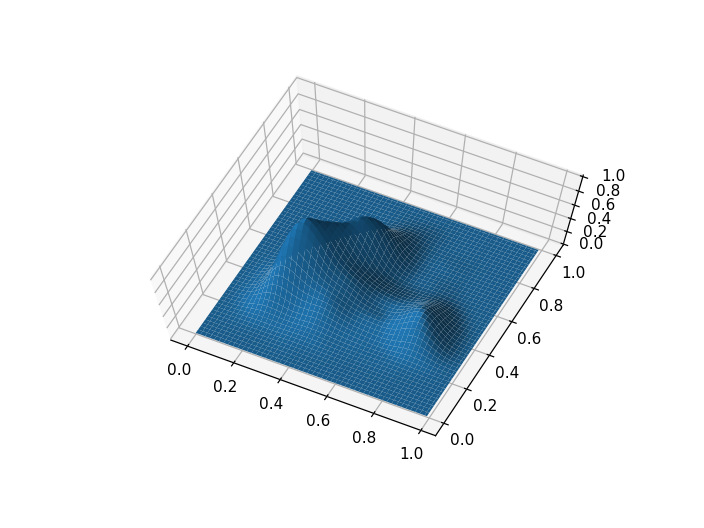

<IPython.core.display.Javascript object>


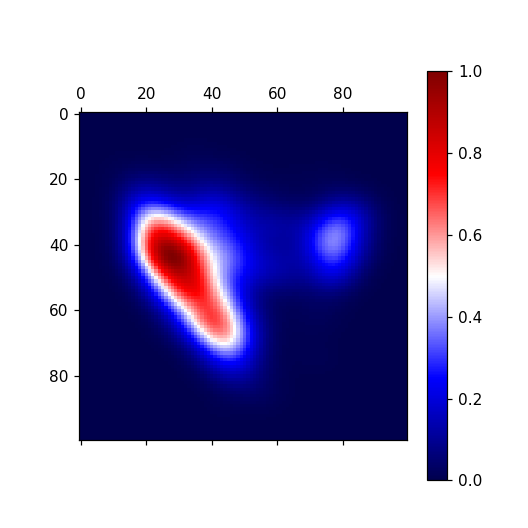

In [25]:
from functionFactory import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
# p=plt.matshow(Z, aspect=1, cmap=plt.get_cmap('seismic'))
plt.show()

p=plt.matshow(Z, aspect=1, cmap=plt.get_cmap('seismic'))
plt.colorbar(p)
plt.show()

In [26]:
# 1
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
from ufl import nabla_grad, nabla_div, grad
from scipy.interpolate import interp2d
from abc import abstractmethod

%matplotlib notebook


In [27]:
# 2
nu = 0.1
cDiff = 0.0027
dbar = 1.6925
cS = 0.5
N = 40*3 # Dimension of the grid
M = 100 # Dimension of the matrices
xmax = 1
tol = 1e-10


In [28]:
# 3
def fun(x, y, muX, muY, sigma):
    return gaussian2d(x, y, muX, muY, sigma, sigma)


def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def gaussian2d(x, y, muX, muY, sigmaX, sigmaY):
    return 1 / (sigmaX * sigmaY * np.sqrt(2 * np.pi)) * np.exp(
        -0.5 * (((x - muX) / sigmaX) ** 2 + ((y - muY) / sigmaY) ** 2))

# N: dimension to, M: dimension from
def interpMat2(N, M, mat):
    xx = np.arange(0, 1.0, 1/(N+1))
    yy = np.arange(0, 1.0, 1/(N+1))
    x = np.arange(0, 1.0, 1/M)
    y = np.arange(0, 1.0, 1/M)
    f = interp2d(x,y,mat)
    mat = f(xx,yy)
    mat = mat.T
    mat = mat.reshape(np.prod(mat.shape))
    return mat

# r = Expression('1 + pow(2, x[0])', degree=2)
# a = Expression('0.5 * (1 - x[0]/xmax)', degree=2, xmax=xmax)
# c_k = Expression('x[0]*x[0]', degree=2)


In [29]:
# 4
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / 100)
X, Y = np.meshgrid(x, y)


<IPython.core.display.Javascript object>


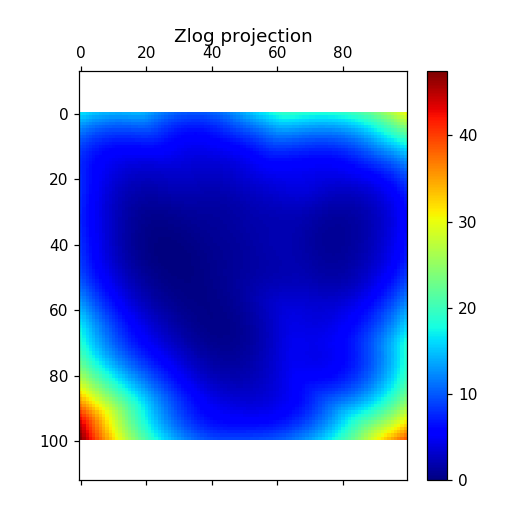

In [30]:
# 4
%matplotlib notebook

zlog = -np.log(np.abs(Z))
zlog = zlog.reshape(X.shape)
plt.matshow(zlog, aspect=1, cmap=plt.get_cmap('jet'))
plt.title('Zlog projection')
plt.colorbar()
plt.axis('equal')
plt.show()


<IPython.core.display.Javascript object>


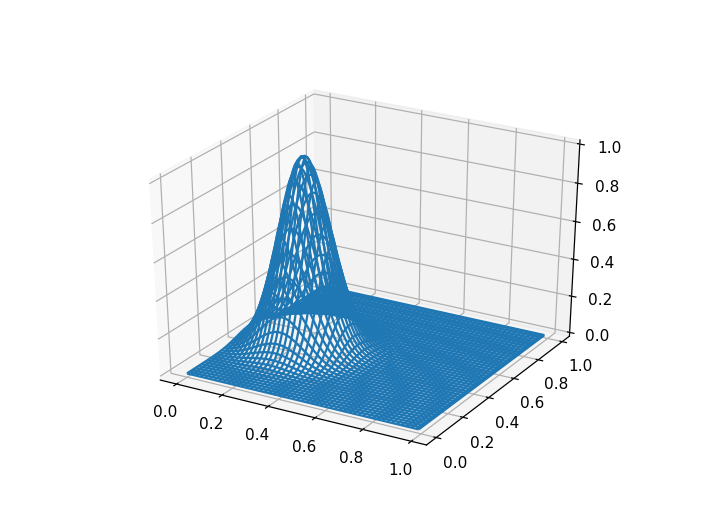

In [37]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / M)
X, Y = np.meshgrid(x, y)
ui = np.array(fun(np.ravel(X), np.ravel(Y), 0.25, 0.45, 0.1))
ui = (ui-min(ui))/max(ui)
Ui = ui.reshape(X.shape)
# Z2 = z2.reshape(X.shape)
# ax.plot_surface(X, Y, Ui) 
# ax.plot_surface(X, Y, Z2, linewidth=1) 
ax.plot_wireframe(X, Y, Ui) 

In [34]:
# 5
parameters['reorder_dofs_serial'] = False
mesh = UnitSquareMesh(N, N)  # 8X8 rectangles, each divided in 2 triangle, hence 128 cells, and 81 (9^2) vertices
Vhat = FunctionSpace(mesh, 'P', 1)  # P returns Lagrangian polynomials, 1 is the degree of the FE

In [38]:
from functionFactory import *
# from makeFunction import * 

<IPython.core.display.Javascript object>


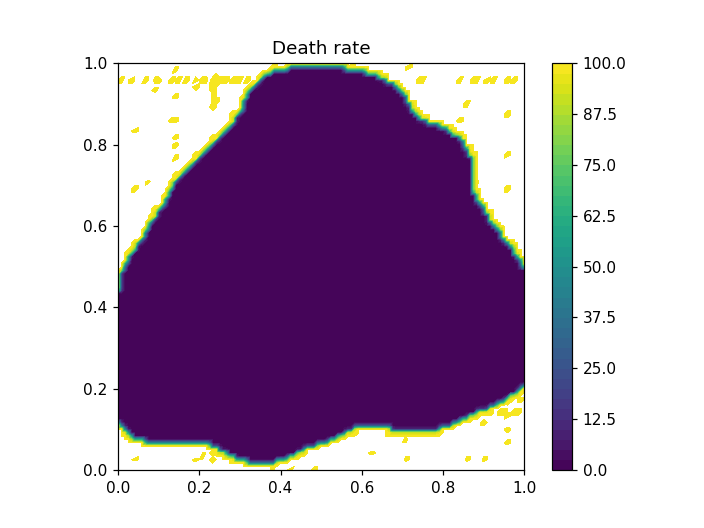

<IPython.core.display.Javascript object>


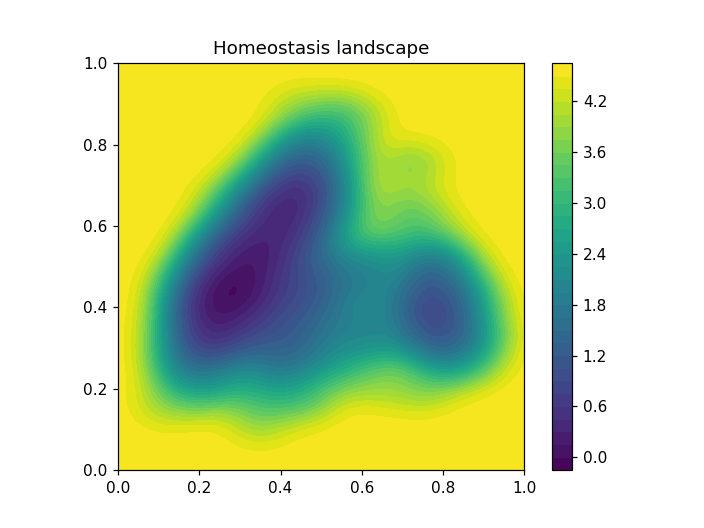

<IPython.core.display.Javascript object>


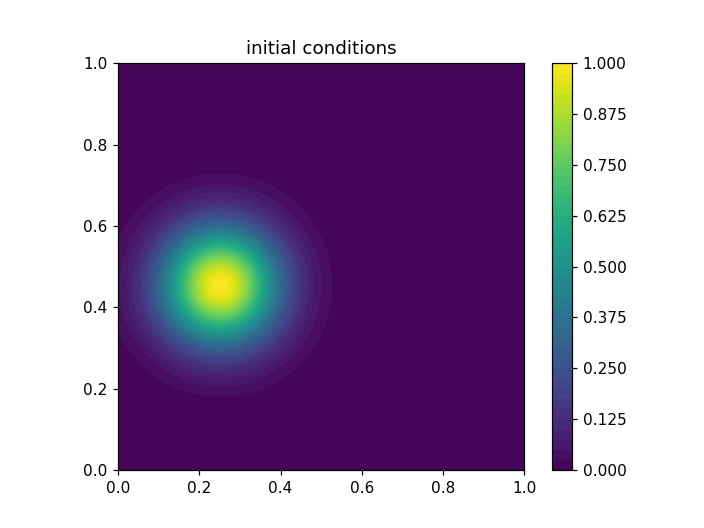

In [39]:
# 6
%matplotlib notebook

factory = functionFactory(Vhat, N, M)
Z +=0.005
zs = Z.ravel()
zexp = np.exp(-((zs-min(zs))/-min(zs)))
uhmst = zexp.reshape(X.shape)
uhmst[uhmst<0.04]=1e-15
cDth = 1. / uhmst.T
cDth[cDth>=0.98] = 100
cDthFct = factory(cDth)
factory.plot(cDth, title='Death rate')

zlog = -np.log(np.abs(zs))
zlogFct = factory(zlog)
factory.plot(zlog,title='Homeostasis landscape')


# Very basic initial conditon
UiFct = factory(0.1*Ui.T)
factory.plot(Ui.T, title='initial conditions')

def rct(x_, y_):
    return -1 + 2**x_


cRctMat = np.array(rct(np.ravel(X), np.ravel(Y)))
cRctMat = cRctMat.reshape(X.shape)
cRctFct = factory(cRctMat.T)
# factory.plot(cRctMat.T,title='Reaction rate')


In [42]:
# 7
def R1(u_):
    uv = u_.vector().get_local()
    cDth = cDthFct.vector().get_local()
    cRct = cRctFct.vector().get_local()
    temp = (cDth * uv)
    temp[temp > dbar] = dbar
    temp = (1 - temp)*cRct
    return temp


def v1():
    return zlogFct


def boundary(x, on_boundary):
    return on_boundary


# Differtiation rate
# Needs to be 1d --> np-ravel
def a(x_,y_):
    return 0.5*(1 - x_/max(x_))

# PT/ direction of the differentiation
def c_k_x(x_, y_):
    return x_**2

def c_k_y(x_, y_):
    return y_**2

<IPython.core.display.Javascript object>


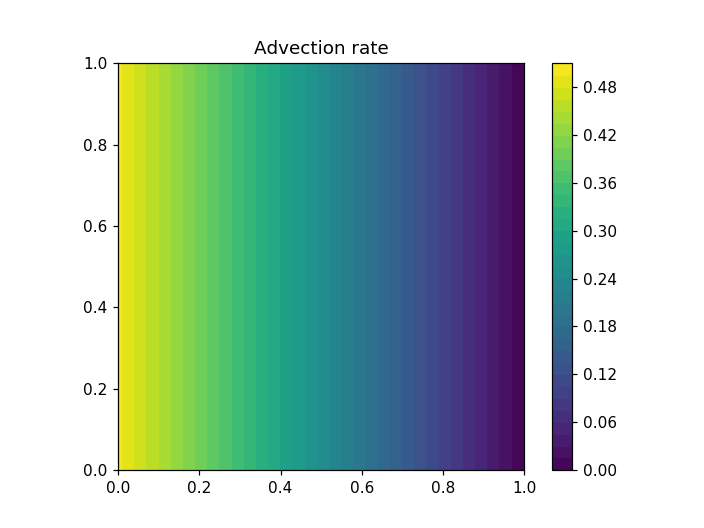

<IPython.core.display.Javascript object>


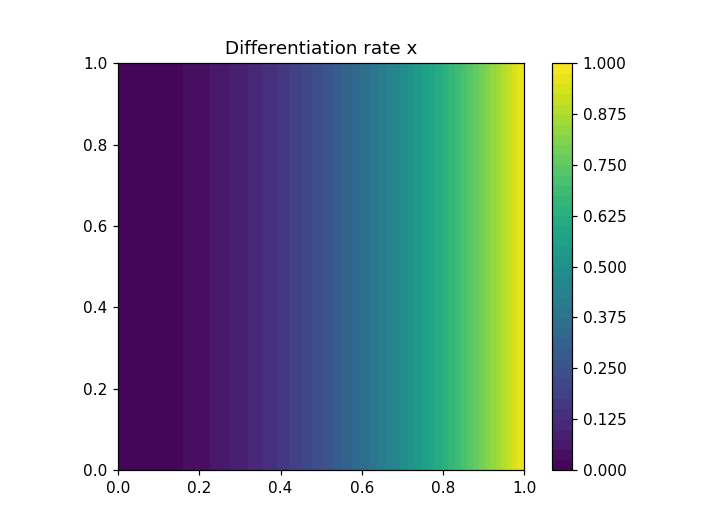

<IPython.core.display.Javascript object>


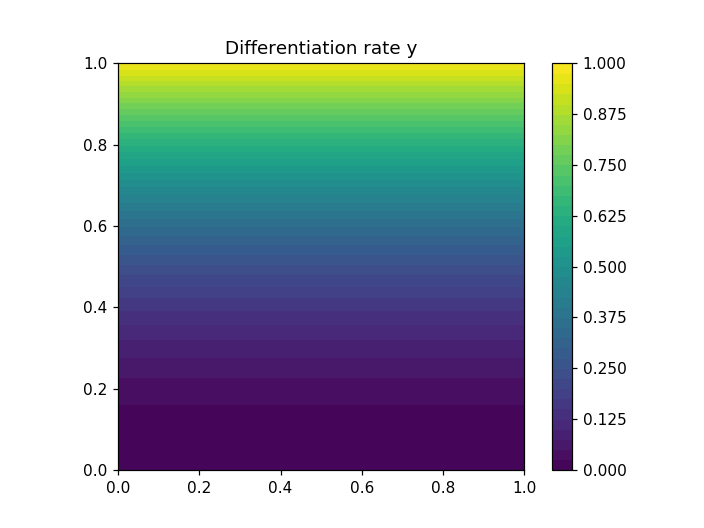

<IPython.core.display.Javascript object>


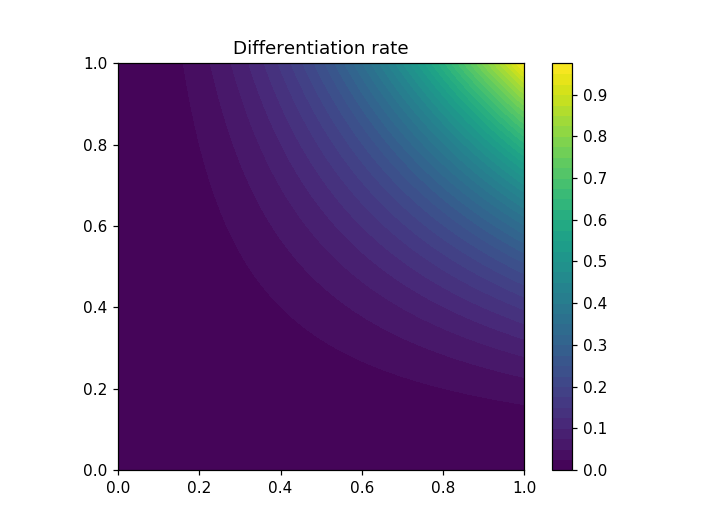

In [45]:
# 6
cAdvMat = np.array(a(np.ravel(X), np.ravel(Y)))
cAdvMat = cAdvMat.reshape(X.shape)
cAdvFct = factory(cAdvMat.T)
factory.plot(cAdvMat.T, title='Advection rate')

# !! Y component in vector space
cAMat_x = np.array(c_k_x(np.ravel(X), np.ravel(Y)))
cAMat_x = cAMat_x.reshape(X.shape)
cAFct_x = factory(cAMat_x.T)
factory.plot(cAMat_x.T, title='Differentiation rate x')


cAMat_y = np.array(c_k_y(np.ravel(X), np.ravel(Y)))
cAMat_y = cAMat_y.reshape(Y.shape)
cAFct_y = factory(cAMat_y.T)
factory.plot(cAMat_y.T, title='Differentiation rate y')
factory.plot(cAMat_y.T*cAMat_x.T, title='Differentiation rate')

def v2_x(u_):
#     cAdv = cDthFct.vector().get_local()
    cAdv = cAdvFct.vector().get_local()
    cA = cAFct_x.vector().get_local()
    cRct = cRctFct.vector().get_local()
    return cA*(1-cAdv)*cRct

def v2_y(u_):
#     cAdv = cDthFct.vector().get_local()
    cAdv = cAdvFct.vector().get_local()
    cA = cAFct_y.vector().get_local()
    cRct = cRctFct.vector().get_local()
    return cA*(1-cAdv)*cRct

t = 0.10: difference = 0.855
t = 0.20: difference = 0.126
t = 0.30: difference = 0.0379
t = 0.40: difference = 0.0283
t = 0.50: difference = 0.0272
t = 0.60: difference = 0.0272
t = 0.70: difference = 0.0276
t = 0.80: difference = 0.0281
t = 0.90: difference = 0.0287
t = 1.00: difference = 0.0294
t = 1.10: difference = 0.03
t = 1.20: difference = 0.0307
t = 1.30: difference = 0.0314
t = 1.40: difference = 0.0322
t = 1.50: difference = 0.0329
t = 1.60: difference = 0.0336
t = 1.70: difference = 0.0344
t = 1.80: difference = 0.0352
t = 1.90: difference = 0.036
t = 2.00: difference = 0.0368
t = 2.10: difference = 0.0377
t = 2.20: difference = 0.0385
t = 2.30: difference = 0.0394
t = 2.40: difference = 0.0403
t = 2.50: difference = 0.0413
t = 2.60: difference = 0.0422
t = 2.70: difference = 0.0432
t = 2.80: difference = 0.0442
t = 2.90: difference = 0.0452
t = 3.00: difference = 0.0462
t = 3.10: difference = 0.0473
t = 3.20: difference = 0.0484
t = 3.30: difference = 0.0495
t = 3.40: diffe

<IPython.core.display.Javascript object>


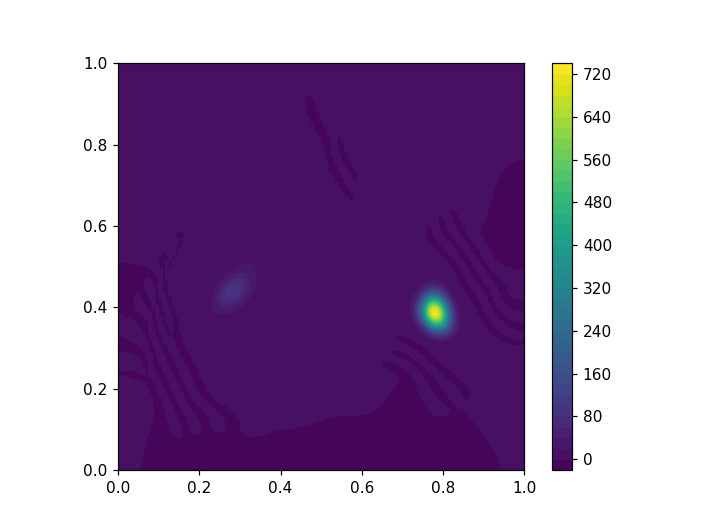

In [47]:
# 8
# %matplotlib notebook

zero = Constant(0)
bc = DirichletBC(Vhat, zero, boundary)

u = TrialFunction(Vhat)  # here it is just defined as an unknown to define a.
v = TestFunction(Vhat)
u_n = Function(Vhat)
R = Function(Vhat)
V2Fct_x = Function(Vhat) 
V2Fct_y = Function(Vhat) 

u_n = interpolate(UiFct, Vhat) # initial value

# plt.figure()
# p = plot(u_n)
# plt.colorbar(p)
# plt.show()

T = 20.0  # final time
num_step = 200
dt = T / num_step
k = 1./dt
tol = 1e-6

R.vector()[:] = R1(u_n)
V2Fct_x.vector()[:] = v2_x(u_n)
V2Fct_y.vector()[:] = v2_y(u_n)

F = dot((u-u_n)*k,v)*dx + nu * dot(grad(u), grad(v)) * dx + dot(nabla_grad(v1())*u, nabla_grad(v)) * dx - \
    dot( R*u, v) * dx - dot(V2Fct_x*u, v.dx(0))* dx - dot(V2Fct_y*u, v.dx(1))* dx
#F = dot((u-u_n)*k,v)*dx + nu * dot(grad(u), grad(v)) * dx + dot(nabla_grad(v1())*u, nabla_grad(v)) * dx - \
#    dot( R*u, v) * dx - dot(V2Fct*u, nabla_grad(v)) * dx
# - dot( v2(u), grad(v)) * dx
# - dot( R(u), v) * dx
# - dot( v2(u), grad(v)) * dx
# - dot( Adv(u), grad(v)) * dx
# dot(nabla_grad(zlogFct)*u, nabla_grad(v)) * dx

u = Function(Vhat)
a = lhs(F)
L = rhs(F)
t = 0

## uncomment to save the solution onto pvd files. Can be used to plot dynamically in paraview
# vtkfile = File('framework/solution.pvd')
# vtkfile << (u_n, t)

for n in range(num_step):
    R.vector()[:] = R1(u_n)
    V2Fct_x.vector()[:] = v2_x(u_n)
    V2Fct_y.vector()[:] = v2_y(u_n)
    t+=dt
    solve(a == L, u, bc)
    u_e = interpolate(u_n, Vhat)
    error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
    print('t = %.2f: difference = %.3g' % (t, error)) #relative errror
#     if (error < tol):
#         break
#     print(max(u.vector()))
#     print(min(u.vector()))
#     vtkfile << (u, t)
#     plt.figure()
#     p = plot(u)
#     plt.colorbar(p)
#     plt.show()
    u_n.assign(u)
    
# print(u.vector().get_local().shape)
# print(max(u.vector()))
# print(min(u.vector()))

plt.figure()
p = plot(u)
plt.colorbar(p)
plt.show()


<IPython.core.display.Javascript object>


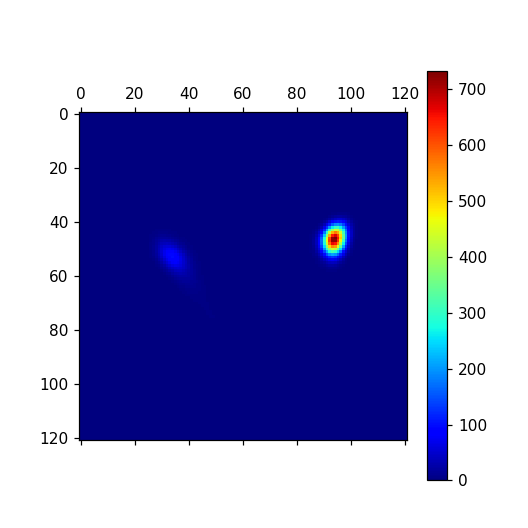

In [48]:
p=plt.matshow(u.vector()[:].reshape(121,121), aspect=1, cmap=plt.get_cmap('jet'))
plt.colorbar(p)

<IPython.core.display.Javascript object>


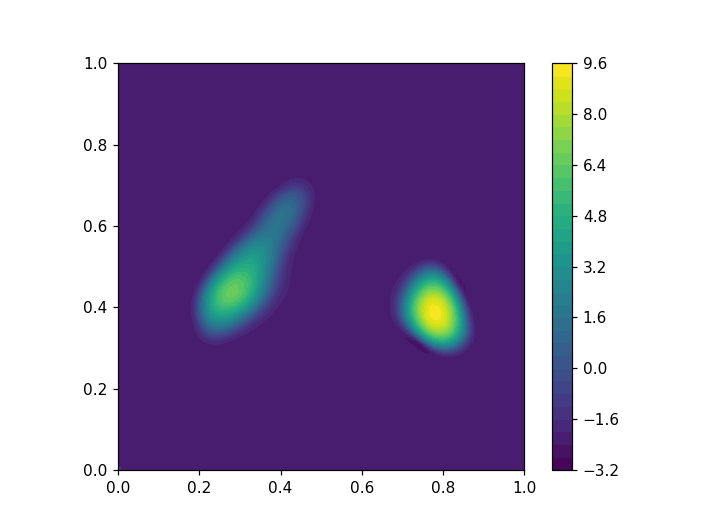

<IPython.core.display.Javascript object>


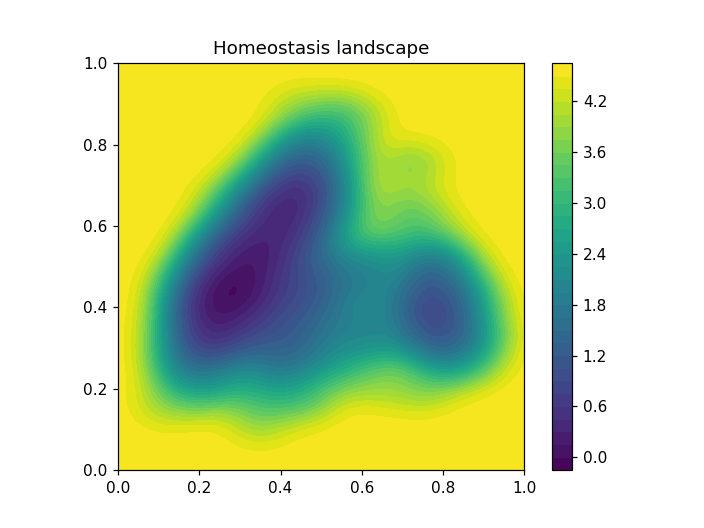

<IPython.core.display.Javascript object>


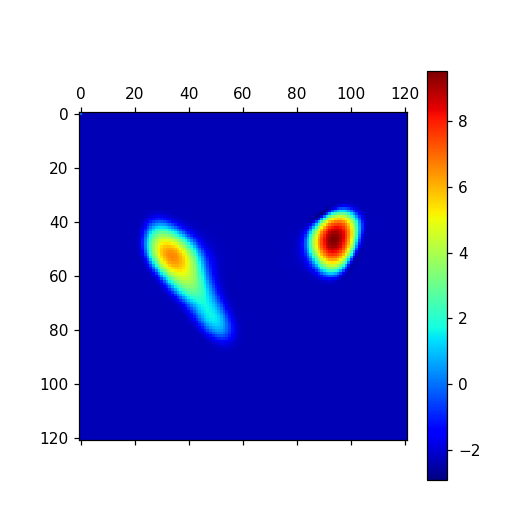

In [56]:
ulog = interpolate(u, Vhat)
ulog.vector()[:] = np.log2(ulog.vector()[:]+0.2)
ulog.vector()[np.isnan(ulog.vector()[:]) ] = 0
ulog.vector()[np.isinf(ulog.vector()[:]) ] = 0
ulog = interpolate(ulog, Vhat)
plt.figure()
p = plot(ulog)
plt.colorbar(p)
plt.show()


factory.plot(zlog,title='Homeostasis landscape')

p=plt.matshow(ulog.vector()[:].reshape(121,121), aspect=1, cmap=plt.get_cmap('jet'))
plt.colorbar(p)

<IPython.core.display.Javascript object>


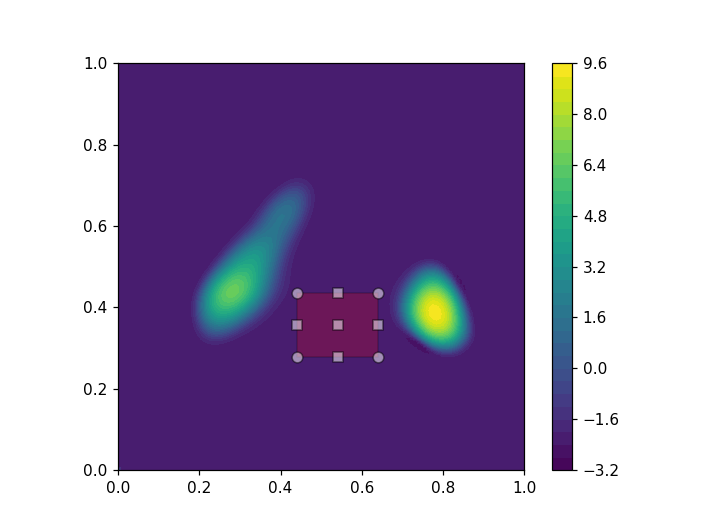


      click  -->  release


In [53]:
# 9
from matplotlib.widgets import RectangleSelector
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    print(" The button you used were: %s %s" % (eclick.button, erelease.button))



fig, current_ax = plt.subplots()                 # make a new plotting range
# p = plot(UiFct)
p = plot(ulog)
plt.colorbar(p)
def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)

print("\n      click  -->  release")

# drawtype is 'box' or 'line' or 'none'
toggle_selector.RS = RectangleSelector(current_ax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
plt.connect('key_press_event', toggle_selector)
plt.show()


In [57]:
# 9
# print(toggle_selector.RS.geometry)
x1, x2, y1 ,y2, z = toggle_selector.RS.geometry.T
# print(x1)
# print(x2)
# print(y1)
# print(y2)
p1 = Point(x1[1], x1[0])
p2 = Point(y1[1], y1[0])

NewMesh = RectangleMesh(p1,p2,N,N)
# plot(NewMesh)
VInt = FunctionSpace(NewMesh, "Lagrange", 2)
uInt = project(u, VInt)
print(assemble(uInt*dx))
# print(assemble(u*dx))
print(uInt.vector().get_local().max())
# print(assemble(uInt*ds))
# print(assemble(uInt*dx))

3.0314112244265397e-05
0.012239100525094328
